In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from researchlib.single_import import *

In [3]:
ctf = [transforms.RandomCrop(32, padding=4), transforms.RandomHorizontalFlip()]

# Load dataset
train_loader = FromPublic('cifar10', 'train', batch_size=512, num_workers=4, custom_tf=ctf)
test_loader = FromPublic('cifar10', 'test', batch_size=512, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Model
model = SENet18(input_dim=3)

# Learning
runner = Runner(model, train_loader, test_loader, optimizer='adam', loss_fn='focal')

In [5]:
for _ in range(3): runner.fit_onecycle(1e-3, mixup_alpha=0.4)

0.3532746269226074
0.5686

Test set: Average loss: 1.5584



0.5123212490844726
0.682

Test set: Average loss: 1.1069



0.5446106903076172
0.7194

Test set: Average loss: 1.0737



In [6]:
runner.fit_cycle(10, 1e-3, mixup_alpha=0.4)

0.5845880084228515
0.7762

Test set: Average loss: 0.8070


0.640424910583496
0.7761

Test set: Average loss: 0.7926


0.6740417443847656
0.8317

Test set: Average loss: 0.6048


0.6409140719604492
0.71

Test set: Average loss: 1.1683


0.6968441955566407
0.8317

Test set: Average loss: 0.6138


0.7310223684692383
0.8531

Test set: Average loss: 0.5205


0.6955190521240234
0.8003

Test set: Average loss: 0.7483


0.696410774230957
0.8439

Test set: Average loss: 0.5628


0.7295260540771484
0.8663

Test set: Average loss: 0.4846


0.7739493286132813
0.8827

Test set: Average loss: 0.4158


0.7386286785888672
0.7829

Test set: Average loss: 0.8014


0.7443577697753906
0.8408

Test set: Average loss: 0.5560


0.7697847500610352
0.8783

Test set: Average loss: 0.4611


0.7792211486816406
0.9076

Test set: Average loss: 0.3469


0.7682433880615235
0.9132

Test set: Average loss: 0.3158


0.7449141189575196
0.8825

Test set: Average loss: 0.4644


0.7947849523925781
0.9094

Test set: Average loss: 0.3352


0.8084860702514648
0.9238

Test set: Average loss: 0.2759


0.7792355459594726
0.9225

Test set: Average loss: 0.2976


0.800555793762207
0.9269

Test set: Average loss: 0.2768


0.7798574563598633
0.9042

Test set: Average loss: 0.3696


0.8099867724609375
0.9114

Test set: Average loss: 0.3163


0.7615763821411132
0.911

Test set: Average loss: 0.3539


0.7869586752319336
0.9143

Test set: Average loss: 0.3105


0.8086096722412109
0.9166

Test set: Average loss: 0.3206


0.7980897671508789
0.9156

Test set: Average loss: 0.3735


0.8345776608276367
0.9243

Test set: Average loss: 0.2826


0.8452132897949218
0.9276

Test set: Average loss: 0.2459


0.8012995175170898
0.9268

Test set: Average loss: 0.2766


0.8156669778442383
0.9018

Test set: Average loss: 0.3780


0.767457269897461
0.9033

Test set: Average loss: 0.3881


0.8296821469116211
0.9086

Test set: Average loss: 0.3220


0.7826703274536133
0.9012

Test set: Average loss: 0.3724


0.7830358932495117
0.9205

Test set: Average loss: 0.3102


0.8464259188842773
0.9245

Test set: Average loss: 0.2715


0.8165602239990234
0.9216

Test set: Average loss: 0.3063


0.801047290649414
0.9321

Test set: Average loss: 0.2576


0.7878000039672851
0.9301

Test set: Average loss: 0.2516


0.7820455737304688
0.9316

Test set: Average loss: 0.2847



0.9316

Test set: Average loss: 0.2886


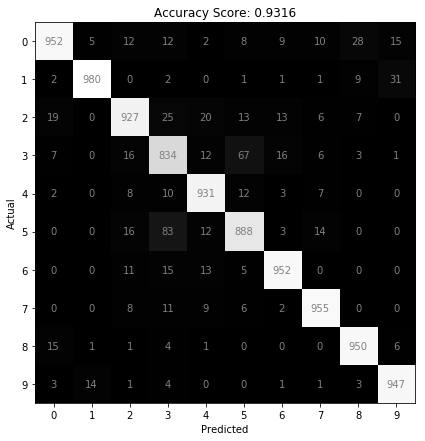

In [7]:
runner.validate(metrics=[ConfusionMatrix(plot=True, classes=10)])

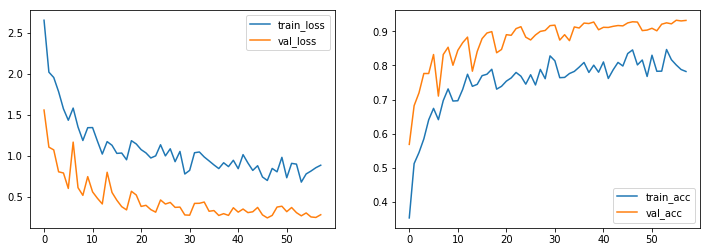

In [8]:
runner.history(plot=True)

In [ ]:
runner.fit_cycle(5, 1e-4, mixup_alpha=0.4)

0.8218643157958985
0.9332

Test set: Average loss: 0.2632


0.7992702563476562
0.9356

Test set: Average loss: 0.2527


0.83094302734375
0.9323

Test set: Average loss: 0.2632


0.790921882019043
0.9314

Test set: Average loss: 0.2822


0.8283942230224609
0.9344

Test set: Average loss: 0.2510


0.8217201605224609
0.9357

Test set: Average loss: 0.2424


0.7951840698242187
0.9344

Test set: Average loss: 0.2695


0.8366062927246094
0.9314

Test set: Average loss: 0.3021


0.8002450637817383
0.9301

Test set: Average loss: 0.3056


0.7923463824462891
0.9359

Test set: Average loss: 0.2598


0.8440702096557617
0.9342

Test set: Average loss: 0.2796


In [12]:
runner.history(plot=True)

AttributeError: 'str' object has no attribute 'get_position'

<Figure size 864x288 with 2 Axes>